IMAGE SEGMENTATION USING U-NET ARCHITECTURE.

This model had a U-shaped structure, one side of the 'U' is Encoding, other Decoding. This model preserves the spatial details and context of the data.
This model excels in precise localization and performs well with limited data, Hence i have chosen U-NET architecture, and adjusted the model in convenient way accourding to the input data.


Install all the required packages (Tensorflow, Numpy, Matplotlib, Scikit-learn, pillow)

(1)Tensorflow - Used for building and training Machine learning and Deep learning models
(2)Numpy - Used for doing the mathematical claculations
(3)Matplotlib - Used for graphical representations
(4)Scikit-learn - Used for processing the data, to split the data to training and test data.

In [2]:
!pip install tensorflow numpy matplotlib scikit-learn pillow

Importing the libraries

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Defining the dimentions of image

In [4]:
IMG_LENGTH = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_LENGTH, IMG_WIDTH, IMG_CHANNELS)
TRAIN_PATH = "G:/My Drive/img" # Images are stores.
MASK_PATH = "G:/My Drive/masks" # Masks of the images are stored.


Creating a function to load the stored data.

In [23]:
def load_data(img_path, mask_path):
    images = []                      #creating an empty list of images.
    masks = []                       #creating an empty list of masks.
    
    img_ids = os.listdir(img_path)   #lists all the image data from the stored directries.
    for img_id in img_ids:
        if img_id.endswith('.jpg'):  # Checking if the image file is a JPG using 'endswith' function.
                                     # Loading the image and resizing it to 128x128.
                                     #'load_img' function Loads an image and resizes it to the specified dimensions.
            img = load_img(os.path.join(img_path, img_id), target_size=(IMG_LENGTH, IMG_WIDTH))
            img = img_to_array(img) / 255.0  # Normalizing to [0, 1] 128*128 = 256.
                                             #'img_to_array' function Converts the loaded image to an array.
            images.append(img)      #adding the normalized data to the images list.

            # For mask file, since the mask images are png, replacing it with jpg.
            mask_id = img_id.replace('.jpg', '.png')
                                    # Load mask and resize to 128x128.
            mask = load_img(os.path.join(mask_path, mask_id), target_size=(IMG_LENGTH, IMG_WIDTH), color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # loading and Normalizing to [0,1] 
            masks.append(mask)      #Adding to the masks list.
    
    images = np.array(images)       #stores images and masks as arrays.
    masks = np.array(masks)
    return images, masks

Loading the data.

In [25]:
X, Y = load_data(TRAIN_PATH, MASK_PATH)

Splitting the data to X_train, X_test, Y_train, Y_test.

In [26]:
# 'Train_test_split' function splits the data to train data and test data.
# Here  we gave 80% of the data for training, 20% for testing.
# random_state=42 is a random number used to ensure reproducibility in splitting the dataset.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Defining the Model.

In [27]:
inputs = tf.keras.layers.Input(shape = IMG_SHAPE) #'inputs' Defines the input layer for the model with the specified image shape.
s = tf.keras.layers.Lambda(lambda x: x)(inputs)

BUILDING THE U-NET ARCHITECTURE

Encoding the path.

'Conv2D' function implements a 2D convolutional layer with 32 filters, kernel size = 3x3, ReLU activation finction, and same padding (Ensures that the edges of the images are not lost by adding extra pixels to the image in the edges), kernal initializer used is 'he_normal'(distribution)

1st layer of Convolutions.

In [9]:
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1) #10% of the data is dropped to prevent underfitting or overfitting.
c1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c1) #2nd convolution since its a 2D convolution.
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) #Takes the max values ofter the convolution.

2nd layer of Convolution after 1st Maxpooling.

In [10]:
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1) #takes input from 1st convolutional layer.
c2 = tf.keras.layers.Dropout(0.1)(c2) #10% of data is dropped to prevent underfitting or overfitting.
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

3nd layer of Convolutions after 2nd Maxpooling.

In [11]:
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2) #takes input from 2nd layer.
c3 = tf.keras.layers.Dropout(0.2)(c3) 
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

4th layer of Convolutions after 3rd Maxpooling.

In [12]:
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

Bottleneck (The bottom of U-NET architecture).

In [13]:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4) #The number of filters is at its maximum (256).
c5 = tf.keras.layers.Dropout(0.3)(c5) # The dropout rate is set to 30%.
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal',padding='same')(c5) 
# Since this is last layer Maxpooling is not required.

Decoding the Path. 

Moving towards up by concatinating with corresponding layer.

6th layer of convolutions (1st layer towards up).

In [14]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same')(c5) #To inverse the layer, we use transpose, numbers of filters is 128 corresponding to c4 layer.
u6 = tf.keras.layers.concatenate([u6, c4]) #concatenates the u6th layer and corresponding c4 layer.
c6 = tf.keras.layers.Conv2D(128,(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6) #This defines the actual layer after concatenation.
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

7th layer of convolutions (2nd from bottom).

In [15]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64,(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

8th layer of convolutions (3rd from bottom).

In [16]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

9th layer of convolutions (4th from bottom).

In [17]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16,(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

Output layer.

In [18]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
#Defines the output layer with a single filter (since its binary segmentation) and uses the sigmoid activation function to produce the probability map.

Compiling the model.

In [19]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#'tf.keras.Model' Constructs the Keras model.
#'binary_crossentropy' is used to calculate the loss finction.
#'adam' optimizer is used to minimize the calculated loss function.
#'accuracy' is used for metrics.

Callback functions.

In [20]:
#'callback' functions are the part of 'model.fit()' function.
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('unet_model.keras', verbose=1, save_best_only=True)
] #Earlystopping- implementing many epochs leads to overfitting, implementing less epochs leads to under fitting, to prevent this we moniter the model with patience = 3.
#ModelCheckpoints- Saves the model at the perticular checkpoints.

Model Fitting and Training.

In [31]:
X_train = np.array(X_train) #converting 'X_train, Y_train' to arrays, since the model.fit will only take array as input.
Y_train = np.array(Y_train)
model.fit(X_train, Y_train, validation_split=0.1, epochs=5, batch_size=2, callbacks=callbacks)
#valitadion split- The percentage of the data going inside, we put aside for validation purpose.
#Epochs- Number of iterations the model should implement.
#Batch size - splitting the model to batches.

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8135 - loss: 0.2276
Epoch 1: val_loss improved from 0.25015 to 0.24470, saving model to unet_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 573ms/step - accuracy: 0.8140 - loss: 0.2294 - val_accuracy: 0.8439 - val_loss: 0.2447
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8313 - loss: 0.2263
Epoch 2: val_loss did not improve from 0.24470
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8305 - loss: 0.2276 - val_accuracy: 0.8269 - val_loss: 0.2449
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8378 - loss: 0.2197
Epoch 3: val_loss did not improve from 0.24470
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 518ms/step - accuracy: 0.8373 - loss: 0.2207 - val_accuracy: 0.8099 - val_loss: 0.2609
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8107 - loss: 0.2862
Epoch 4: val_loss did not improve from 0.24470
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step - accuracy: 0.8116 - loss: 0.2859 - val_accuracy: 0.8324 - val_

Function to display the predictions.
#using matplotlib for graphical representation of images.

In [32]:
def display_predictions(images, masks, predictions, num=3):
    plt.figure(figsize=(15, num * 4))  # Set figure size for visibility
    for i in range(num):
        plt.subplot(num, 3, i * 3 + 1) #creats subplots.
        plt.imshow(images[i])
        plt.title("Original Image") #Title of graph.
        plt.axis('off')  # Removing the axis for a cleaner look
        
        plt.subplot(num, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')  # Removing the axis for a cleaner look
        
        plt.subplot(num, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')  # Turn off axis for a cleaner look

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

Making predictions on test data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


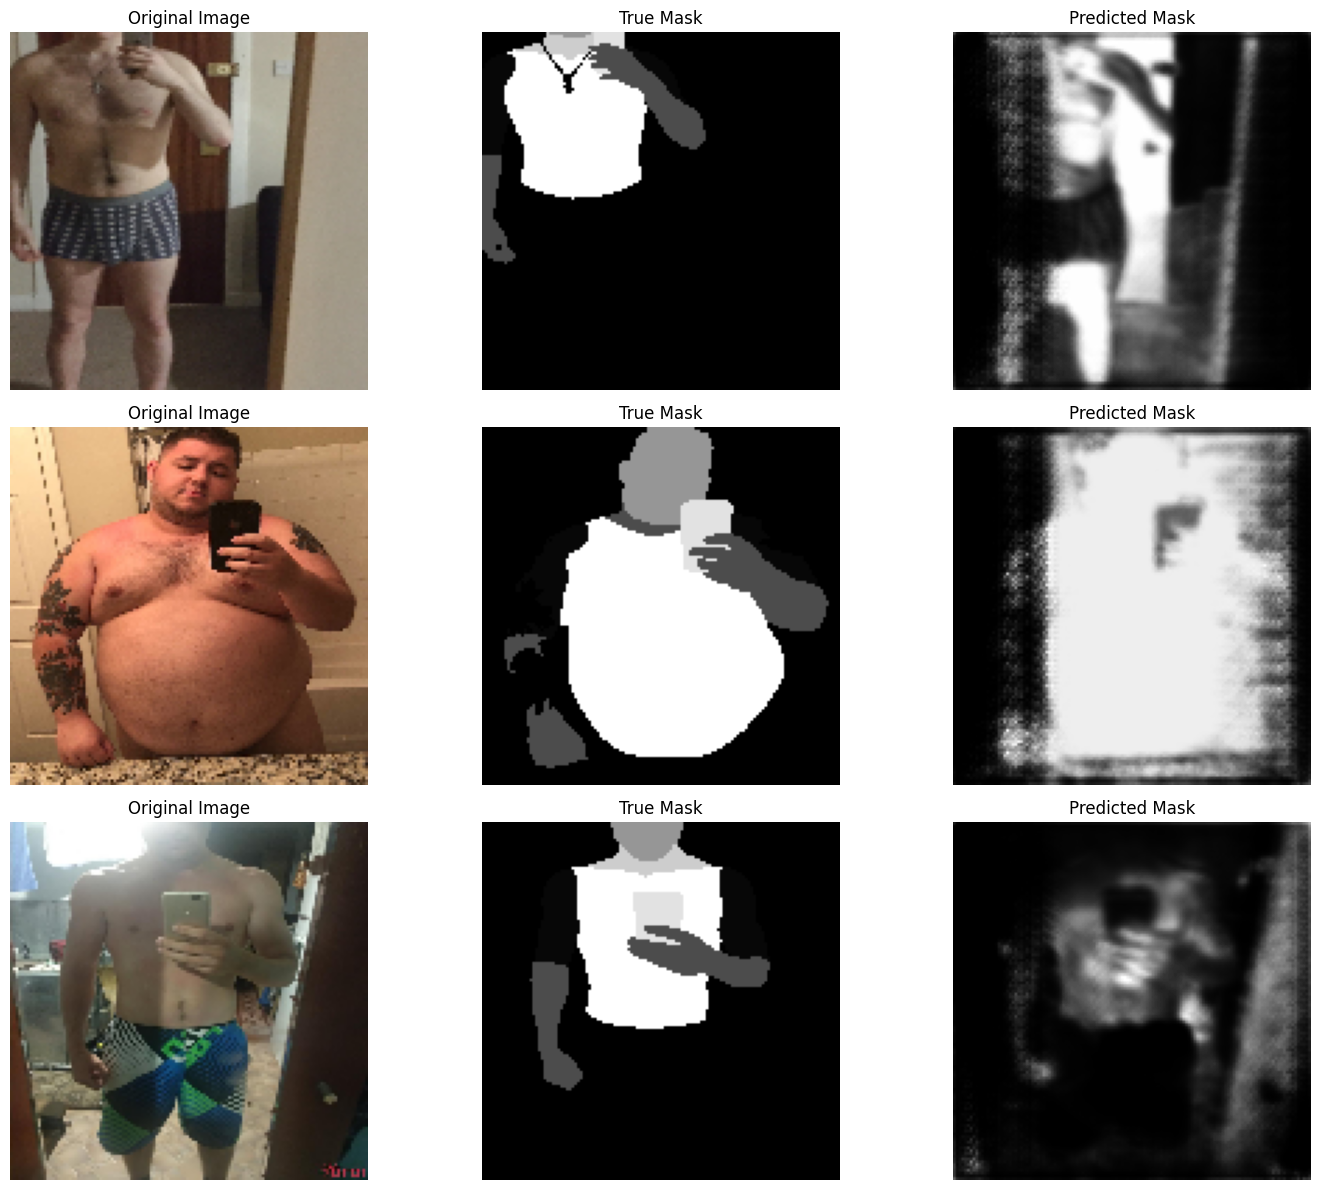

In [34]:
preds_test = model.predict(X_test) #'predict' function here takes input as 'X_test' and gives out 'preds_test' = predicted mask.
display_predictions(X_test, Y_test, preds_test)

Since the dataset is small and the number of iterations are very less, the predicted masks are not up-to the mark. 